In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import os
import re
import copy
import json
import time
import pickle
from multiprocessing import Pool
from datetime import datetime
from collections import defaultdict
from abc import ABC, abstractmethod


import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from map4 import MAP4Calculator

from ga import SequenceGA, ScaffoldGA, GA
from baye import get_fitted_model, Map4Fingerprint, SequenceDescriptors, TanimotoSimilarityKernel, DMTSimulation
from baye import AcqScoring, expected_improvement, probability_of_improvement, greedy
from helm import build_helm_string, parse_helm
from helm_genetic_operators import HELMGeneticOperators
from mhc import read_pssm_file, MHCIPeptideScorer
from utils import affinity_binding_to_energy, energy_to_affinity_binding, compute_probability_matrix, plot_results

## Read dataset

In [16]:
mhci = pd.read_csv('../mhc/binding_data_2013/bdata.20130222.mhci.csv')
print(mhci[mhci['mhc_allele'].str.contains("HLA")]['mhc_allele'].unique().shape)

(119,)


In [17]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (8 <= mhci['length']) &
            (mhci['length'] <= 11) &
            (~mhci['affinity_binding'].isin(dirty_values))]

## Genetic operators on HELM strings

In [40]:
with open('HELMCoreLibrary.json') as f:
    helm_core_library = json.load(f)

monomer_names = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
smiles = [x['smiles'] for x in helm_core_library if x['symbol'] in monomer_names and x['monomerType'] == 'Backbone']
    
probability_matrix = compute_probability_matrix(smiles)

helmgo = HELMGeneticOperators(monomer_names, probability_matrix)

## Generate random peptides

In [41]:
n_peptides = [1]
peptide_lengths = [9]
energy_bounds = [-8.235, -4.944] # about between 1 uM and 250 uM
#energy_bounds = [-4.944, -4.531] # about between 250 uM and 500 uM
#energy_bounds = [-4.531, -4.118] # about between 500 uM and 1 mM
#energy_bounds = [-8.649, -8.235] # about between 500 nM and 1uM
energy_cutoff = -4.11 # 1 mM
#energy_cutoff = -4.944 # 250 uM
#energy_cutoff = -8.235 # 1 uM

pssm_files = ['../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-8.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-9.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-10.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-11.txt']
mps = MHCIPeptideScorer(pssm_files, mhci, energy_cutoff=energy_cutoff)

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(n_peptides[0], peptide_lengths, energy_bounds)

clusters = defaultdict(list)
for i, sequence in enumerate(random_peptides):
    clusters[sequence.count('.')].append(i)
print('Distribution:', ['%d: %d' % (k, len(clusters[k])) for k in sorted(clusters.keys())])
print('')

print(len(random_peptides))
print(random_peptides)
print(random_peptide_scores)

----- Peptide global -----
N peptide: 8471
R2: 0.620
RMSD : 1.177 kcal/mol

Distribution: ['9: 1']

1
['PEPTIDE1{C.G.I.L.Y.K.V.W.F}$$$$V2.0']
[-5.71702952]


In [72]:
map4 = Map4Fingerprint(input_type='helm')

parameters = {'n_candidates': 96, 'GA': SequenceGA, 'helmgo': helmgo, 'oracle': mps,
              'acq_function': expected_improvement, 'kernel': TanimotoSimilarityKernel, 'seq_transformer': map4, 
              'n_gen': 100, 'n_children': 1000, 'temperature': 0.025, 'elitism': True, 'tolerance': 1e-3, 'total_attempts': 10}

dmt = DMTSimulation(4, 10)
df = dmt.run(random_peptides, random_peptide_scores, **parameters)

Run: 1
Exp dataset size: (1, 4096)


Init.
N pep:  1
Best peptide: -5.717
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
Non binding pep        : 000


Generation: 1
N 001 sequence opt - Score: -0.004 - Seq: 9 - PEPTIDE1{A.G.I.L.Y.K.V.W.F}$$$$V2.0
N 002 sequence opt - Score: -0.004 - Seq: 9 - PEPTIDE1{A.G.H.L.Y.K.V.W.F}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.003988 - Seq: 9 - PEPTIDE1{A.G.H.L.Y.K.V.W.F}$$$$V2.0
Final selection: ['9: 96']

N pep:  97
Best peptide: -8.366
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 003
Non binding pep        : 000

Generation: 2
N 001 sequence opt - Score: -0.467 - Seq: 9 - PEPTIDE1{C.I.I.L.Y.V.V.W.A}$$$$V2.0
N 

N 001 sequence opt - Score: -0.004 - Seq: 9 - PEPTIDE1{A.G.I.L.Y.K.V.W.F}$$$$V2.0
N 002 sequence opt - Score: -0.004 - Seq: 9 - PEPTIDE1{A.F.I.L.Y.K.V.W.F}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.003988 - Seq: 9 - PEPTIDE1{A.F.I.L.Y.K.V.W.F}$$$$V2.0
Final selection: ['9: 96']

N pep:  97
Best peptide: -8.292
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
Non binding pep        : 000

Generation: 2
N 001 sequence opt - Score: -0.372 - Seq: 9 - PEPTIDE1{C.M.I.L.Y.L.V.P.F}$$$$V2.0
N 002 sequence opt - Score: -0.525 - Seq: 9 - PEPTIDE1{C.M.I.L.Y.L.V.W.F}$$$$V2.0
N 003 sequence opt - Score: -0.541 - Seq: 9 - PEPTIDE1{C.M.I.L.Y.L.W.W.F}$$$$V2.0
N 004 sequence opt - Score: -0.567 - Seq: 9 - PEPTIDE1{I.M.I.L.Y.L.W.W.F}$$$$V2.0
N 005 sequence opt - Score: -0.567 - Seq: 9 - PEPTIDE1{I.M.I.L.Y.L.W.W.F}$$$$V2.0
N

N 001 sequence opt - Score: -0.463 - Seq: 9 - PEPTIDE1{C.G.W.L.Y.L.V.W.V}$$$$V2.0
N 002 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 003 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 004 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 005 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 006 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 007 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 008 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 009 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 010 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 011 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 012 sequence opt - Score: -0.680 - Seq: 9 - PEPTIDE1{C.I.W.L.Y.L.V.W.V}$$$$V2.0
N 013 sequence o

N 014 sequence opt - Score: -0.074 - Seq: 9 - PEPTIDE1{L.M.I.C.Y.I.F.F.V}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.073804 - Seq: 9 - PEPTIDE1{L.M.I.C.Y.I.F.F.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  385
Best peptide: -12.668
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 087
N pep under -11 kcal/mol: 244
N pep under -10 kcal/mol: 289
N pep under -9 kcal/mol: 290
N pep under -8 kcal/mol: 296
Non binding pep        : 000

Run: 7
Exp dataset size: (1, 4096)


Init.
N pep:  1
Best peptide: -5.717
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
Non binding pep        : 000


Generation: 1
N 001 sequence opt - Score: -0.004 - Seq: 9 - PEPTIDE1{A.G.I.L.Y.K.V.W.F}$$$$V2.0
N 002 sequence opt - Score: -0.004 - Seq: 9 - PEPTIDE1{A.G.I.K.Y.K.V.W.F}$$

N 004 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
N 005 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
N 006 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
N 007 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
N 008 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
N 009 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
N 010 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
N 011 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
N 012 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.119796 - Seq: 9 - PEPTIDE1{I.M.F.D.Y.L.F.W.L}$$$$V2.0
Final selection: ['9: 96']

N pep:  385
Best peptide: -12.574
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep 


N pep:  193
Best peptide: -12.137
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 008
N pep under -10 kcal/mol: 065
N pep under -9 kcal/mol: 081
N pep under -8 kcal/mol: 096
Non binding pep        : 003

Generation: 3
N 001 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.I.I.C.Y.I.F.F.V}$$$$V2.0
N 002 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.I.I.C.Y.I.F.F.V}$$$$V2.0
N 003 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.I.I.C.Y.I.F.F.V}$$$$V2.0
N 004 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.I.I.C.Y.I.F.F.V}$$$$V2.0
N 005 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.I.I.C.Y.I.F.F.V}$$$$V2.0
N 006 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.I.I.C.Y.I.F.F.V}$$$$V2.0
N 007 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.I.I.C.Y.I.F.F.V}$$$$V2.0
N 008 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.I.I.C.Y.I.F.F.V}$$$$V2.0
N 009 sequence opt - Score: -0.109 - Seq: 9 - PEPTIDE1{F.

In [78]:
seq_descriptors = SequenceDescriptors(pd.read_csv('../mhc/pca.csv'), input_type='helm')

parameters = {'n_candidates': 96, 'GA': SequenceGA, 'helmgo': helmgo, 'oracle': mps,
              'acq_function': expected_improvement, 'kernel': gpytorch.kernels.RBFKernel, 'seq_transformer': seq_descriptors, 
              'n_gen': 100, 'n_children': 1000, 'temperature': 0.025, 'elitism': True, 'tolerance': 1e-3, 'total_attempts': 10}

dmt = DMTSimulation(4, 10)
df = dmt.run(random_peptides, random_peptide_scores, **parameters)

Run: 1
Exp dataset size: (1, 45)


Init.
N pep:  1
Best peptide: -5.717
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 000
Non binding pep        : 000


Generation: 1
N 001 sequence opt - Score: -0.004 - Seq: 9 - PEPTIDE1{A.G.I.L.Y.K.V.W.F}$$$$V2.0
N 002 sequence opt - Score: -0.004 - Seq: 9 - PEPTIDE1{A.G.D.L.Y.K.V.W.F}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.003988 - Seq: 9 - PEPTIDE1{A.G.D.L.Y.K.V.W.F}$$$$V2.0
Final selection: ['9: 96']

N pep:  97
Best peptide: -8.693
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 006
Non binding pep        : 001

Generation: 2
N 001 sequence opt - Score: -0.546 - Seq: 9 - PEPTIDE1{C.L.I.L.Y.N.V.W.V}$$$$V2.0
N 00

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


N 001 sequence opt - Score: -0.858 - Seq: 9 - PEPTIDE1{M.L.W.A.Y.I.I.F.V}$$$$V2.0
N 002 sequence opt - Score: -1.327 - Seq: 9 - PEPTIDE1{M.L.W.A.Y.I.M.F.V}$$$$V2.0
N 003 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 004 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 005 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 006 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 007 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 008 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 009 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 010 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 011 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 012 sequence opt - Score: -1.594 - Seq: 9 - PEPTIDE1{M.L.W.D.Y.I.M.F.V}$$$$V2.0
N 013 sequence o


N pep:  193
Best peptide: -10.461
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 021
N pep under -9 kcal/mol: 090
N pep under -8 kcal/mol: 098
Non binding pep        : 000

Generation: 3
N 001 sequence opt - Score: -0.290 - Seq: 9 - PEPTIDE1{C.I.F.D.Y.Q.F.W.V}$$$$V2.0
N 002 sequence opt - Score: -0.423 - Seq: 9 - PEPTIDE1{C.I.F.A.Y.F.F.W.V}$$$$V2.0
N 003 sequence opt - Score: -0.522 - Seq: 9 - PEPTIDE1{C.L.F.L.Y.F.F.F.V}$$$$V2.0
N 004 sequence opt - Score: -0.590 - Seq: 9 - PEPTIDE1{C.L.F.A.Y.F.F.F.V}$$$$V2.0
N 005 sequence opt - Score: -0.620 - Seq: 9 - PEPTIDE1{C.L.F.A.Y.T.F.F.V}$$$$V2.0
N 006 sequence opt - Score: -0.620 - Seq: 9 - PEPTIDE1{C.L.F.A.Y.T.F.F.V}$$$$V2.0
N 007 sequence opt - Score: -0.620 - Seq: 9 - PEPTIDE1{C.L.F.A.Y.T.F.F.V}$$$$V2.0
N 008 sequence opt - Score: -0.620 - Seq: 9 - PEPTIDE1{C.L.F.A.Y.T.F.F.V}$$$$V2.0
N 009 sequence opt - Score: -0.620 - Seq: 9 - PEPTIDE1{C.

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


N 001 sequence opt - Score: -0.486 - Seq: 9 - PEPTIDE1{C.L.W.G.Y.I.F.F.V}$$$$V2.0
N 002 sequence opt - Score: -0.664 - Seq: 9 - PEPTIDE1{M.L.W.G.Y.I.F.F.V}$$$$V2.0
N 003 sequence opt - Score: -0.716 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
N 004 sequence opt - Score: -0.716 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
N 005 sequence opt - Score: -0.716 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
N 006 sequence opt - Score: -0.716 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
N 007 sequence opt - Score: -0.716 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
N 008 sequence opt - Score: -0.716 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
N 009 sequence opt - Score: -0.716 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
N 010 sequence opt - Score: -0.716 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.715776 - Seq: 9 - PEPTIDE1{H.L.W.G.Y.I.F.P.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  385
Best peptide: -13.713
N pep

N 001 sequence opt - Score: -0.879 - Seq: 9 - PEPTIDE1{C.L.Y.W.Y.V.I.W.V}$$$$V2.0
N 002 sequence opt - Score: -1.049 - Seq: 9 - PEPTIDE1{C.L.Y.D.Y.V.I.W.V}$$$$V2.0
N 003 sequence opt - Score: -1.134 - Seq: 9 - PEPTIDE1{C.L.Y.D.Y.V.F.W.V}$$$$V2.0
N 004 sequence opt - Score: -1.185 - Seq: 9 - PEPTIDE1{C.L.Y.D.Y.I.F.W.V}$$$$V2.0
N 005 sequence opt - Score: -1.221 - Seq: 9 - PEPTIDE1{C.L.Y.E.Y.I.F.W.V}$$$$V2.0
N 006 sequence opt - Score: -1.228 - Seq: 9 - PEPTIDE1{C.L.Y.E.Y.I.F.Y.V}$$$$V2.0
N 007 sequence opt - Score: -1.228 - Seq: 9 - PEPTIDE1{C.L.Y.E.Y.I.F.Y.V}$$$$V2.0
N 008 sequence opt - Score: -1.228 - Seq: 9 - PEPTIDE1{C.L.Y.E.Y.I.F.Y.V}$$$$V2.0
N 009 sequence opt - Score: -1.228 - Seq: 9 - PEPTIDE1{C.L.Y.E.Y.I.F.Y.V}$$$$V2.0
N 010 sequence opt - Score: -1.228 - Seq: 9 - PEPTIDE1{C.L.Y.E.Y.I.F.Y.V}$$$$V2.0
N 011 sequence opt - Score: -1.228 - Seq: 9 - PEPTIDE1{C.L.Y.E.Y.I.F.Y.V}$$$$V2.0
N 012 sequence opt - Score: -1.228 - Seq: 9 - PEPTIDE1{C.L.Y.E.Y.I.F.Y.V}$$$$V2.0
N 013 sequence o

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/botorch/fit.py:128: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(w.message, w.category)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/botorch/fit.py:128: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(w.message, w.category)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/botorch/fit.py:128: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(w.message, w.category)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


N 001 sequence opt - Score: -0.820 - Seq: 9 - PEPTIDE1{G.L.Y.D.Y.I.F.Y.V}$$$$V2.0
N 002 sequence opt - Score: -0.971 - Seq: 9 - PEPTIDE1{G.L.Y.W.W.I.F.Y.V}$$$$V2.0
N 003 sequence opt - Score: -1.012 - Seq: 9 - PEPTIDE1{G.L.Y.W.W.I.W.Y.V}$$$$V2.0
N 004 sequence opt - Score: -1.012 - Seq: 9 - PEPTIDE1{G.L.Y.W.W.I.W.Y.V}$$$$V2.0
N 005 sequence opt - Score: -1.033 - Seq: 9 - PEPTIDE1{G.I.W.W.Y.I.W.Y.V}$$$$V2.0
N 006 sequence opt - Score: -1.043 - Seq: 9 - PEPTIDE1{G.I.W.W.W.I.W.Y.V}$$$$V2.0
N 007 sequence opt - Score: -1.042 - Seq: 9 - PEPTIDE1{G.I.W.W.W.I.W.Y.V}$$$$V2.0
N 008 sequence opt - Score: -1.063 - Seq: 9 - PEPTIDE1{G.I.W.D.W.I.W.Y.V}$$$$V2.0
N 009 sequence opt - Score: -1.063 - Seq: 9 - PEPTIDE1{G.I.W.D.W.I.W.Y.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -1.062621 - Seq: 9 - PEPTIDE1{G.I.W.D.W.I.W.Y.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  385
Best peptide: -12.998
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 1

N 012 sequence opt - Score: -0.741 - Seq: 9 - PEPTIDE1{C.V.F.F.Y.L.V.W.V}$$$$V2.0
N 013 sequence opt - Score: -0.741 - Seq: 9 - PEPTIDE1{C.V.F.F.Y.L.V.W.V}$$$$V2.0
N 014 sequence opt - Score: -0.741 - Seq: 9 - PEPTIDE1{C.V.F.F.Y.L.V.W.V}$$$$V2.0
N 015 sequence opt - Score: -0.741 - Seq: 9 - PEPTIDE1{C.V.F.F.Y.L.V.W.V}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.740621 - Seq: 9 - PEPTIDE1{C.V.F.F.Y.L.V.W.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  193
Best peptide: -10.996
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 060
N pep under -9 kcal/mol: 096
N pep under -8 kcal/mol: 098
Non binding pep        : 000

Generation: 3
N 001 sequence opt - Score: -0.980 - Seq: 9 - PEPTIDE1{C.A.W.W.Y.L.I.W.V}$$$$V2.0
N 002 sequence opt - Score: -1.079 - Seq: 9 - PEPTIDE1{C.A.W.W.Y.L.I.F.V}$$$$V2.0
N 003 sequence opt - Score: -1.079 - Seq: 9 - PEPTIDE1{C.A.W

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/botorch/fit.py:128: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(w.message, w.category)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/botorch/fit.py:128: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(w.message, w.category)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/botorch/fit.py:128: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(w.message, w.category)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


N 001 sequence opt - Score: -0.649 - Seq: 9 - PEPTIDE1{C.L.W.W.Y.I.M.F.V}$$$$V2.0
N 002 sequence opt - Score: -0.883 - Seq: 9 - PEPTIDE1{V.L.W.W.Y.I.M.F.V}$$$$V2.0
N 003 sequence opt - Score: -0.889 - Seq: 9 - PEPTIDE1{V.L.W.W.Y.I.M.I.V}$$$$V2.0
N 004 sequence opt - Score: -0.889 - Seq: 9 - PEPTIDE1{V.L.W.W.Y.I.M.I.V}$$$$V2.0
N 005 sequence opt - Score: -0.889 - Seq: 9 - PEPTIDE1{V.L.W.W.Y.I.M.I.V}$$$$V2.0
N 006 sequence opt - Score: -0.889 - Seq: 9 - PEPTIDE1{V.L.W.W.Y.I.M.I.V}$$$$V2.0
N 007 sequence opt - Score: -0.889 - Seq: 9 - PEPTIDE1{V.L.W.W.Y.I.M.I.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.888740 - Seq: 9 - PEPTIDE1{V.L.W.W.Y.I.M.I.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  385
Best peptide: -12.698
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 058
N pep under -11 kcal/mol: 102
N pep under -10 kcal/mol: 200
N pep under -9 kcal/mol: 288
N pep under -8 kcal/mol: 290
Non binding pep        : 000

Run: 8
Exp da

/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/gpytorch/distributions/multivariate_normal.py:263: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  NumericalWarning,


N 001 sequence opt - Score: -1.304 - Seq: 9 - PEPTIDE1{W.A.L.D.Y.I.C.F.V}$$$$V2.0
N 002 sequence opt - Score: -1.423 - Seq: 9 - PEPTIDE1{W.A.L.D.Y.R.C.F.V}$$$$V2.0
N 003 sequence opt - Score: -1.538 - Seq: 9 - PEPTIDE1{W.A.F.D.Y.R.C.F.V}$$$$V2.0
N 004 sequence opt - Score: -1.593 - Seq: 9 - PEPTIDE1{W.C.P.D.Y.R.C.F.V}$$$$V2.0
N 005 sequence opt - Score: -1.662 - Seq: 9 - PEPTIDE1{W.C.P.D.Y.I.C.F.V}$$$$V2.0
N 006 sequence opt - Score: -1.667 - Seq: 9 - PEPTIDE1{W.C.P.D.W.I.C.F.V}$$$$V2.0
N 007 sequence opt - Score: -1.667 - Seq: 9 - PEPTIDE1{W.C.P.D.W.I.C.F.V}$$$$V2.0
N 008 sequence opt - Score: -1.667 - Seq: 9 - PEPTIDE1{W.C.P.D.W.I.C.F.V}$$$$V2.0
N 009 sequence opt - Score: -1.667 - Seq: 9 - PEPTIDE1{W.C.P.D.W.I.C.F.V}$$$$V2.0
N 010 sequence opt - Score: -1.667 - Seq: 9 - PEPTIDE1{W.C.P.D.W.I.C.F.V}$$$$V2.0
N 011 sequence opt - Score: -1.667 - Seq: 9 - PEPTIDE1{W.C.P.D.W.I.C.F.V}$$$$V2.0
N 012 sequence opt - Score: -1.667 - Seq: 9 - PEPTIDE1{W.C.P.D.W.I.C.F.V}$$$$V2.0
N 013 sequence o

N 008 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
N 009 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
N 010 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
N 011 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
N 012 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
N 013 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
N 014 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
N 015 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
N 016 sequence opt - Score: -3.254 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -3.254040 - Seq: 9 - PEPTIDE1{C.K.F.L.Y.I.I.W.I}$$$$V2.0
Final selection: ['9: 96']

N pep:  193
Best peptide: -9.367
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep u

N 013 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
N 014 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
N 015 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
N 016 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
N 017 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
N 018 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
N 019 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
N 020 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
N 021 sequence opt - Score: -1.508 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -1.507961 - Seq: 9 - PEPTIDE1{W.K.W.G.W.I.P.Y.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  289
Best peptide: -12.432
N pep under -14 kcal/mol: 000
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 0

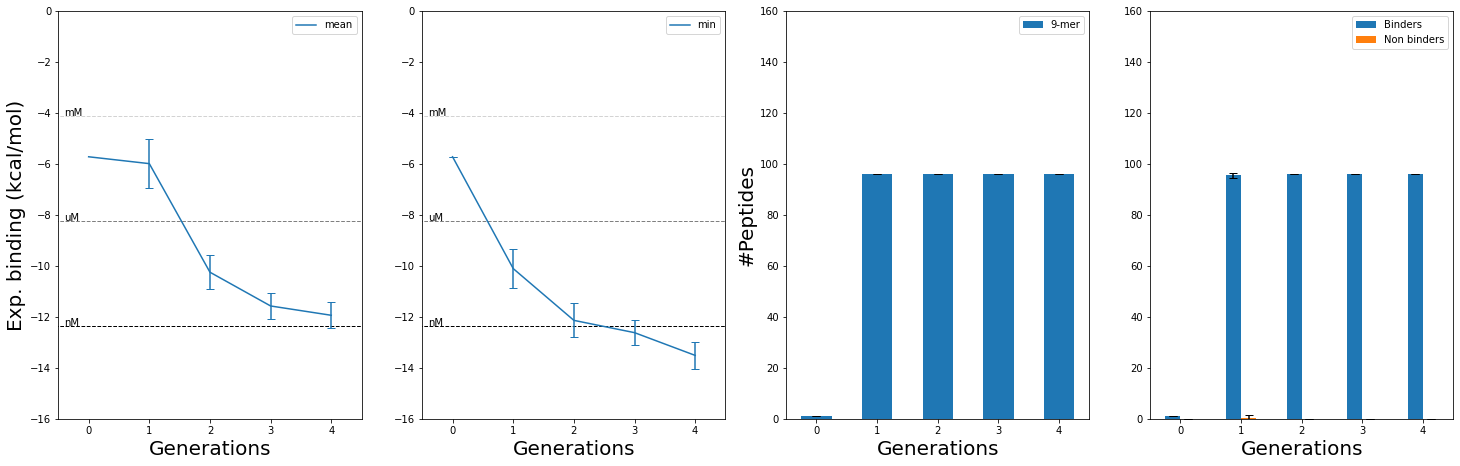

In [73]:
date = datetime.now().strftime("%d-%m-%Y_%H:%M")
#run_name = '%s_150-9-mers_500nM-1uM-1uM_G4-1000-0.5_L10-500-0.1_8-to-11-mers_pi' % date
run_name = 'test_14_non-greedy-ei'
df.to_csv('data_%s.csv' % run_name, index=False)

plot_results(df, run_name)

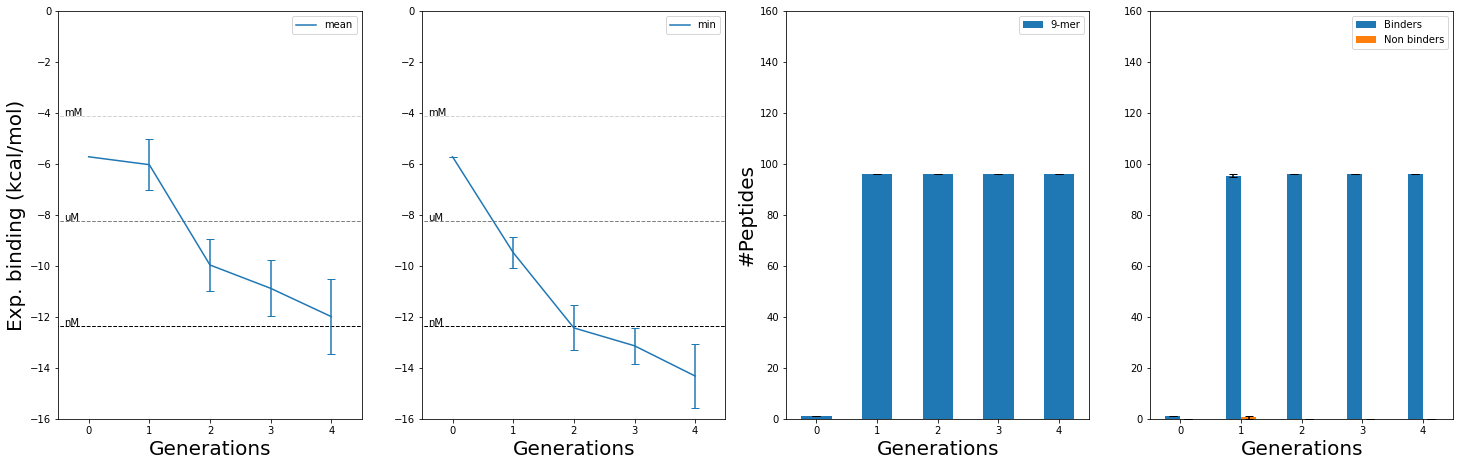

In [79]:
date = datetime.now().strftime("%d-%m-%Y_%H:%M")
#run_name = '%s_150-9-mers_500nM-1uM-1uM_G4-1000-0.5_L10-500-0.1_8-to-11-mers_pi' % date
run_name = 'test_15_non-greedy-ei_pca'
df.to_csv('data_%s.csv' % run_name, index=False)

plot_results(df, run_name)

In [19]:
parameters = {'n_candidates': 96, 'n_gen': 2, 'helmgo': helmgo, 'acq_function': greedy, 'kernel': TanimotoSimilarityKernel,
              'sequence_n_gen': 100, 'sequence_n_children': 1000, 'sequence_temperature': 0.025, 'sequence_elitism': True, 
              'sequence_tolerance': 1e-3, 'sequence_total_attempts': 10, 'sequence_n_process': 4,
              'scaffold_n_gen': 1, 'scaffold_n_children': 1000, 'scaffold_temperature': 0.05, 'scaffold_elitism': True,
              'scaffold_only_terminus': True, 'scaffold_minimum_size': 8, 'scaffold_maximum_size': 11}

dmt = DMTExperience(random_peptides, random_peptide_scores)
df = dmt.run(4, 10, **parameters)

Run: 1
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.202
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
Non binding pep        : 000


Generation: 1
N 1 sequence opt - Score: -0.051 - Seq: 9 - PEPTIDE1{A.Y.F.L.A.E.F.F.A}$$$$V2.0
End scaffold opt - Score: -0.051 - Seq: 9 - PEPTIDE1{A.Y.F.L.A.E.F.F.A}$$$$V2.0
N 1 sequence opt - Score: -0.073 - Seq: 9 - PEPTIDE1{L.Q.L.V.Y.C.F.W.A}$$$$V2.0
N 1 sequence opt - Score: -0.065 - Seq: 8 - PEPTIDE1{M.L.V.Y.C.F.W.Y}$$$$V2.0
N 1 sequence opt - Score: -0.062 - Seq: 10 - PEPTIDE1{L.M.L.V.Y.C.F.W.Y.A}$$$$V2.0
N 2 sequence opt - Score: -0.065 - Seq: 8 - PEPTIDE1{M.L.V.Y.C.F.W.Y}$$$$V2.0
N 1 sequence opt - Score: -0.038 - Seq: 11 - PEPTIDE1{L.M.L.V.Y.C.F.W.Y.I.V}$$$$V2.0
N 2 sequence opt - Score: -0.096 - Seq: 9 - PEPTIDE1{L.M.L.V.Y.C.F.W.A}$$$$V2.0
N 3 sequence opt - Score: -0.065 - Seq: 8 - PEPTIDE1{M.

N 21 sequence opt - Score: -0.110 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.W.A}$$$$V2.0
N 26 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 17 sequence opt - Score: -0.069 - Seq: 11 - PEPTIDE1{A.M.L.A.Y.A.F.W.Y.A.A}$$$$V2.0
N 19 sequence opt - Score: -0.090 - Seq: 10 - PEPTIDE1{A.L.M.Y.A.F.W.Y.A.A}$$$$V2.0
N 22 sequence opt - Score: -0.110 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.W.A}$$$$V2.0
N 27 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.099204 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 18 sequence opt - Score: -0.069 - Seq: 11 - PEPTIDE1{A.M.L.A.Y.A.F.W.Y.A.A}$$$$V2.0
N 20 sequence opt - Score: -0.090 - Seq: 10 - PEPTIDE1{A.L.M.Y.A.F.W.Y.A.A}$$$$V2.0
N 23 sequence opt - Score: -0.110 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.W.A}$$$$V2.0
N 24 sequence opt - Score: -0.110 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.W.A}$$$$V2.0
N 19 sequence opt - Score: -0.069 - Seq: 11 - 

N 10 sequence opt - Score: -0.093 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.C}$$$$V2.0
N 9 sequence opt - Score: -0.102 - Seq: 9 - PEPTIDE1{L.M.L.S.F.K.F.W.A}$$$$V2.0
N 7 sequence opt - Score: -0.068 - Seq: 10 - PEPTIDE1{M.L.A.S.A.Y.A.F.W.A}$$$$V2.0
N 11 sequence opt - Score: -0.093 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.C}$$$$V2.0
N 8 sequence opt - Score: -0.068 - Seq: 10 - PEPTIDE1{M.L.A.S.A.Y.A.F.W.A}$$$$V2.0
N 10 sequence opt - Score: -0.102 - Seq: 9 - PEPTIDE1{L.M.L.S.F.K.F.W.A}$$$$V2.0
N 12 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 7 sequence opt - Score: -0.051 - Seq: 11 - PEPTIDE1{A.M.L.V.Y.C.F.W.Y.V.A}$$$$V2.0
N 11 sequence opt - Score: -0.107 - Seq: 9 - PEPTIDE1{L.M.L.A.Y.C.F.W.A}$$$$V2.0
N 8 sequence opt - Score: -0.051 - Seq: 11 - PEPTIDE1{A.M.L.V.Y.C.F.W.Y.V.A}$$$$V2.0
N 13 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 9 sequence opt - Score: -0.068 - Seq: 10 - PEPTIDE1{M.L.A.S.A.Y.A.F.W.A}$$$$V2.0
N 12 sequence opt - Sco

N 26 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 18 sequence opt - Score: -0.066 - Seq: 11 - PEPTIDE1{L.M.L.V.S.I.F.S.S.A.T}$$$$V2.0
N 20 sequence opt - Score: -0.080 - Seq: 10 - PEPTIDE1{A.L.M.Y.A.F.W.Y.V.A}$$$$V2.0
N 24 sequence opt - Score: -0.131 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.P.A}$$$$V2.0
N 27 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 21 sequence opt - Score: -0.090 - Seq: 10 - PEPTIDE1{A.L.M.Y.A.F.W.F.A.A}$$$$V2.0
N 28 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.099204 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 25 sequence opt - Score: -0.131 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.P.A}$$$$V2.0
N 19 sequence opt - Score: -0.075 - Seq: 11 - PEPTIDE1{L.M.L.A.S.I.F.S.S.A.T}$$$$V2.0
N 22 sequence opt - Score: -0.090 - Seq: 10 - PEPTIDE1{A.L.M.Y.A.F.W.F.A.A}$$$$V2.0
N 20 sequence opt - Score: -0.075 - Seq: 11 - PEPTIDE1{L.M.L.A.S.I

N 3 sequence opt - Score: -0.065 - Seq: 8 - PEPTIDE1{M.L.V.Y.C.F.W.Y}$$$$V2.0
N 2 sequence opt - Score: -0.062 - Seq: 10 - PEPTIDE1{L.M.L.V.Y.C.F.W.Y.A}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.062190 - Seq: 10 - PEPTIDE1{L.M.L.V.Y.C.F.W.Y.A}$$$$V2.0
N 3 sequence opt - Score: -0.084 - Seq: 9 - PEPTIDE1{L.M.L.V.Y.C.F.W.I}$$$$V2.0
N 2 sequence opt - Score: -0.046 - Seq: 11 - PEPTIDE1{L.S.L.V.Y.C.F.W.Y.A.A}$$$$V2.0
N 4 sequence opt - Score: -0.075 - Seq: 8 - PEPTIDE1{M.L.V.Y.C.F.W.I}$$$$V2.0
N 4 sequence opt - Score: -0.096 - Seq: 9 - PEPTIDE1{L.M.L.V.Y.C.F.W.A}$$$$V2.0
N 5 sequence opt - Score: -0.075 - Seq: 8 - PEPTIDE1{M.L.V.Y.C.F.W.I}$$$$V2.0
N 5 sequence opt - Score: -0.096 - Seq: 9 - PEPTIDE1{L.M.L.V.Y.C.F.W.A}$$$$V2.0
N 3 sequence opt - Score: -0.046 - Seq: 11 - PEPTIDE1{L.S.L.V.Y.C.F.W.Y.A.A}$$$$V2.0
N 6 sequence opt - Score: -0.082 - Seq: 8 - PEPTIDE1{M.L.A.Y.C.F.W.I}$$$$V2.0
N 4 sequence opt - Score: -0.046 - Seq: 11 - PEPTIDE1{L.S.L.V.Y.C.F.W.Y.A.A}$$$

N 42 sequence opt - Score: -0.083 - Seq: 11 - PEPTIDE1{A.M.L.I.S.A.W.I.S.A.T}$$$$V2.0
N 43 sequence opt - Score: -0.083 - Seq: 11 - PEPTIDE1{A.M.L.I.S.A.W.I.S.A.T}$$$$V2.0
N 44 sequence opt - Score: -0.083 - Seq: 11 - PEPTIDE1{A.M.L.I.S.A.W.I.S.A.T}$$$$V2.0
N 45 sequence opt - Score: -0.083 - Seq: 11 - PEPTIDE1{A.M.L.I.S.A.W.I.S.A.T}$$$$V2.0
N 46 sequence opt - Score: -0.083 - Seq: 11 - PEPTIDE1{A.M.L.I.S.A.W.I.S.A.T}$$$$V2.0
N 47 sequence opt - Score: -0.083 - Seq: 11 - PEPTIDE1{A.M.L.I.S.A.W.I.S.A.T}$$$$V2.0
N 48 sequence opt - Score: -0.083 - Seq: 11 - PEPTIDE1{A.M.L.I.S.A.W.I.S.A.T}$$$$V2.0
N 49 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.A}$$$$V2.0
N 50 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.A}$$$$V2.0
N 51 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.A}$$$$V2.0
N 52 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.A}$$$$V2.0
N 53 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1

N 28 sequence opt - Score: -0.080 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.A.A.A}$$$$V2.0
N 29 sequence opt - Score: -0.080 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.A.A.A}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.079727 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.A.A.A}$$$$V2.0
N 1 sequence opt - Score: -0.056 - Seq: 9 - PEPTIDE1{Q.L.V.Y.C.F.W.Y.A}$$$$V2.0
End scaffold opt - Score: -0.056 - Seq: 9 - PEPTIDE1{Q.L.V.Y.C.F.W.Y.A}$$$$V2.0
N 1 sequence opt - Score: -0.065 - Seq: 8 - PEPTIDE1{M.L.V.Y.C.F.W.Y}$$$$V2.0
N 1 sequence opt - Score: -0.059 - Seq: 9 - PEPTIDE1{M.L.V.Y.C.F.W.Y.S}$$$$V2.0
N 1 sequence opt - Score: -0.052 - Seq: 10 - PEPTIDE1{Q.L.V.Y.C.F.W.Y.A.A}$$$$V2.0
N 2 sequence opt - Score: -0.076 - Seq: 8 - PEPTIDE1{M.L.V.Y.C.F.W.L}$$$$V2.0
N 2 sequence opt - Score: -0.065 - Seq: 9 - PEPTIDE1{A.M.F.L.A.P.F.F.A}$$$$V2.0
N 1 sequence opt - Score: -0.041 - Seq: 11 - PEPTIDE1{L.M.L.V.Y.C.F.W.Y.A.Y}$$$$V2.0
N 3 sequence opt - Score: -0.077 - Seq: 8 - P

N 10 sequence opt - Score: -0.117 - Seq: 9 - PEPTIDE1{M.M.L.S.Y.I.Y.A.V}$$$$V2.0
N 11 sequence opt - Score: -0.117 - Seq: 9 - PEPTIDE1{M.M.L.S.Y.I.Y.A.V}$$$$V2.0
N 12 sequence opt - Score: -0.117 - Seq: 9 - PEPTIDE1{M.M.L.S.Y.I.Y.A.V}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.117281 - Seq: 9 - PEPTIDE1{M.M.L.S.Y.I.Y.A.V}$$$$V2.0
N 9 sequence opt - Score: -0.009 - Seq: 10 - PEPTIDE1{L.M.M.L.S.Y.I.Y.A.V}$$$$V2.0
N 10 sequence opt - Score: -0.009 - Seq: 10 - PEPTIDE1{L.M.M.L.S.Y.I.Y.A.V}$$$$V2.0
N 11 sequence opt - Score: -0.009 - Seq: 10 - PEPTIDE1{L.M.M.L.S.Y.I.Y.A.V}$$$$V2.0
N 12 sequence opt - Score: -0.009 - Seq: 10 - PEPTIDE1{L.M.M.L.S.Y.I.Y.A.V}$$$$V2.0
N 13 sequence opt - Score: -0.009 - Seq: 10 - PEPTIDE1{L.M.M.L.S.Y.I.Y.A.V}$$$$V2.0
N 14 sequence opt - Score: -0.009 - Seq: 10 - PEPTIDE1{L.M.M.L.S.Y.I.Y.A.V}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.009182 - Seq: 10 - PEPTIDE1{L.M.M.L.S.Y.

N 42 sequence opt - Score: -0.097 - Seq: 10 - PEPTIDE1{L.M.L.S.A.W.F.I.P.A}$$$$V2.0
N 40 sequence opt - Score: -0.090 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.T}$$$$V2.0
N 43 sequence opt - Score: -0.097 - Seq: 10 - PEPTIDE1{L.M.L.S.A.W.F.I.P.A}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.097433 - Seq: 10 - PEPTIDE1{L.M.L.S.A.W.F.I.P.A}$$$$V2.0
N 41 sequence opt - Score: -0.090 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.T}$$$$V2.0
N 42 sequence opt - Score: -0.090 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.T}$$$$V2.0
N 43 sequence opt - Score: -0.090 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.T}$$$$V2.0
N 44 sequence opt - Score: -0.090 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.T}$$$$V2.0
N 45 sequence opt - Score: -0.090 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.T}$$$$V2.0
N 46 sequence opt - Score: -0.090 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.T}$$$$V2.0
N 47 sequence opt - Score: -0.090 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.T}$$$$V2.0
N 48 sequence opt - Score: -

N 5 sequence opt - Score: -0.155 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.P.V}$$$$V2.0
N 6 sequence opt - Score: -0.155 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.P.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.155428 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.P.V}$$$$V2.0
N 3 sequence opt - Score: -0.002 - Seq: 11 - PEPTIDE1{A.A.L.M.L.S.Y.I.A.A.V}$$$$V2.0
N 4 sequence opt - Score: -0.002 - Seq: 11 - PEPTIDE1{A.A.L.M.L.S.Y.I.A.A.V}$$$$V2.0
N 5 sequence opt - Score: -0.002 - Seq: 11 - PEPTIDE1{A.A.L.M.L.S.Y.I.A.A.V}$$$$V2.0
N 6 sequence opt - Score: -0.002 - Seq: 11 - PEPTIDE1{A.A.L.M.L.S.Y.I.A.A.V}$$$$V2.0
N 7 sequence opt - Score: -0.002 - Seq: 11 - PEPTIDE1{A.A.L.M.L.S.Y.I.A.A.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.001674 - Seq: 11 - PEPTIDE1{A.A.L.M.L.S.Y.I.A.A.V}$$$$V2.0
End GA opt - Score: -0.155 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.P.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  342
Best peptide: -12.669
N pep under -13 kcal/mol: 000
N pep under -12 kc

N 9 sequence opt - Score: -0.069 - Seq: 11 - PEPTIDE1{A.M.L.A.Y.A.F.W.Y.A.A}$$$$V2.0
N 15 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 10 sequence opt - Score: -0.069 - Seq: 11 - PEPTIDE1{A.M.L.A.Y.A.F.W.Y.A.A}$$$$V2.0
N 11 sequence opt - Score: -0.073 - Seq: 10 - PEPTIDE1{A.L.V.Y.V.F.W.Y.I.A}$$$$V2.0
N 16 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 12 sequence opt - Score: -0.073 - Seq: 10 - PEPTIDE1{A.L.V.Y.V.F.W.Y.I.A}$$$$V2.0
N 17 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 11 sequence opt - Score: -0.069 - Seq: 11 - PEPTIDE1{A.M.L.A.Y.A.F.W.Y.A.A}$$$$V2.0
N 18 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 12 sequence opt - Score: -0.069 - Seq: 11 - PEPTIDE1{A.M.L.A.Y.A.F.W.Y.A.A}$$$$V2.0
N 13 sequence opt - Score: -0.073 - Seq: 10 - PEPTIDE1{A.L.V.Y.V.F.W.Y.I.A}$$$$V2.0
N 19 sequence opt - Score: -0.099 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 14 seque

N 3 sequence opt - Score: -0.045 - Seq: 11 - PEPTIDE1{L.M.L.V.Y.C.F.W.Y.A.L}$$$$V2.0
N 6 sequence opt - Score: -0.086 - Seq: 8 - PEPTIDE1{M.L.A.Y.C.F.W.L}$$$$V2.0
N 4 sequence opt - Score: -0.045 - Seq: 11 - PEPTIDE1{L.M.L.V.Y.C.F.W.Y.A.L}$$$$V2.0
N 7 sequence opt - Score: -0.086 - Seq: 8 - PEPTIDE1{M.L.A.Y.C.F.W.L}$$$$V2.0
N 6 sequence opt - Score: -0.094 - Seq: 9 - PEPTIDE1{L.M.L.V.F.C.F.W.A}$$$$V2.0
N 7 sequence opt - Score: -0.094 - Seq: 9 - PEPTIDE1{L.M.L.V.F.C.F.W.A}$$$$V2.0
N 8 sequence opt - Score: -0.089 - Seq: 8 - PEPTIDE1{M.L.A.Y.C.F.W.A}$$$$V2.0
N 5 sequence opt - Score: -0.055 - Seq: 11 - PEPTIDE1{L.M.L.V.Y.C.F.W.A.I.A}$$$$V2.0
N 9 sequence opt - Score: -0.089 - Seq: 8 - PEPTIDE1{M.L.A.Y.C.F.W.A}$$$$V2.0
N 8 sequence opt - Score: -0.102 - Seq: 9 - PEPTIDE1{L.M.L.A.F.C.F.W.A}$$$$V2.0
N 6 sequence opt - Score: -0.055 - Seq: 11 - PEPTIDE1{L.M.L.V.Y.C.F.W.A.I.A}$$$$V2.0
N 10 sequence opt - Score: -0.089 - Seq: 8 - PEPTIDE1{M.L.A.Y.C.F.W.A}$$$$V2.0
N 9 sequence opt - Score: -0.

N 1 sequence opt - Score: -0.005 - Seq: 9 - PEPTIDE1{L.M.L.A.Y.I.F.W.V}$$$$V2.0
End scaffold opt - Score: -0.005 - Seq: 9 - PEPTIDE1{L.M.L.A.Y.I.F.W.V}$$$$V2.0
N 1 sequence opt - Score: -0.000 - Seq: 8 - PEPTIDE1{L.M.L.A.Y.I.F.P}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.000022 - Seq: 8 - PEPTIDE1{L.M.L.A.Y.I.F.P}$$$$V2.0
N 1 sequence opt - Score: -0.023 - Seq: 9 - PEPTIDE1{L.M.L.A.Y.V.F.W.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.023074 - Seq: 9 - PEPTIDE1{L.M.L.A.Y.V.F.W.V}$$$$V2.0
N 1 sequence opt - Score: -0.003 - Seq: 10 - PEPTIDE1{L.M.L.A.Y.I.F.W.V.A}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.003150 - Seq: 10 - PEPTIDE1{L.M.L.A.Y.I.F.W.V.A}$$$$V2.0
N 1 sequence opt - Score: -0.001 - Seq: 11 - PEPTIDE1{L.M.L.A.Y.I.F.W.V.V.A}$$$$V2.0
N 2 sequence opt - Score: -0.001 - Seq: 11 - PEPTIDE1{L.M.L.A.Y.I.F.W.V.V.A}$$$$V2.0
N 3 sequence opt - Score: -0.001 - Seq: 11 - PEPTIDE1{L.M.L.A.Y.I.F.W.V.V.A}$$$$V2.0
Pare

End sequence opt - Score: -0.099204 - Seq: 8 - PEPTIDE1{M.L.A.Y.I.F.W.A}$$$$V2.0
N 19 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.A.F.I.S.A.A}$$$$V2.0
N 24 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.A.A}$$$$V2.0
N 20 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.A.F.I.S.A.A}$$$$V2.0
N 25 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.A.A}$$$$V2.0
N 21 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.A.F.I.S.A.A}$$$$V2.0
N 26 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.A.A}$$$$V2.0
N 22 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.A.F.I.S.A.A}$$$$V2.0
N 27 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.A.A}$$$$V2.0
N 23 sequence opt - Score: -0.084 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.I.S.A.A}$$$$V2.0
N 28 sequence opt - Score: -0.120 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.A.A}$$$$V2.0
N 29 sequence opt - Score: -0.128 - Seq: 9 - PEPTIDE1{L.M.F.S.F.K.I.P.A}$$$$V2.0
Par

N 1 sequence opt - Score: -0.006 - Seq: 10 - PEPTIDE1{A.L.M.L.S.F.I.Y.A.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.005938 - Seq: 10 - PEPTIDE1{A.L.M.L.S.F.I.Y.A.V}$$$$V2.0
N 1 sequence opt - Score: -0.001 - Seq: 11 - PEPTIDE1{L.M.L.S.F.I.Y.A.V.A.V}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.000830 - Seq: 11 - PEPTIDE1{L.M.L.S.F.I.Y.A.V.A.V}$$$$V2.0
N 2 sequence opt - Score: -0.085 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.A.V}$$$$V2.0
N 3 sequence opt - Score: -0.085 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.A.V}$$$$V2.0
N 4 sequence opt - Score: -0.085 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.A.V}$$$$V2.0
N 5 sequence opt - Score: -0.085 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.A.V}$$$$V2.0
N 6 sequence opt - Score: -0.085 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.A.V}$$$$V2.0
N 7 sequence opt - Score: -0.085 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.A.V}$$$$V2.0
N 8 sequence opt - Score: -0.085 - Seq: 9 - PEPTIDE1{L.M.L.S.Y.I.F.A.V}$$$$V2.0
N 9 sequence opt - Score: -0.085 - Seq

N 15 sequence opt - Score: -0.067 - Seq: 11 - PEPTIDE1{A.M.L.I.F.A.F.V.I.A.A}$$$$V2.0
N 17 sequence opt - Score: -0.083 - Seq: 10 - PEPTIDE1{G.M.Y.S.L.A.I.A.P.A}$$$$V2.0
N 20 sequence opt - Score: -0.112 - Seq: 9 - PEPTIDE1{L.M.L.S.F.I.F.W.A}$$$$V2.0
N 16 sequence opt - Score: -0.072 - Seq: 11 - PEPTIDE1{L.M.L.A.F.K.F.A.A.P.A}$$$$V2.0
N 18 sequence opt - Score: -0.083 - Seq: 10 - PEPTIDE1{G.M.Y.S.L.A.I.A.P.A}$$$$V2.0
N 21 sequence opt - Score: -0.112 - Seq: 9 - PEPTIDE1{L.M.L.S.F.I.F.W.A}$$$$V2.0
N 17 sequence opt - Score: -0.072 - Seq: 11 - PEPTIDE1{L.M.L.A.F.K.F.A.A.P.A}$$$$V2.0
N 19 sequence opt - Score: -0.084 - Seq: 10 - PEPTIDE1{G.M.Y.S.L.W.I.A.P.A}$$$$V2.0
N 22 sequence opt - Score: -0.112 - Seq: 9 - PEPTIDE1{L.M.L.S.F.I.F.W.A}$$$$V2.0
N 18 sequence opt - Score: -0.074 - Seq: 11 - PEPTIDE1{A.M.L.A.F.K.F.A.A.P.A}$$$$V2.0
N 20 sequence opt - Score: -0.084 - Seq: 10 - PEPTIDE1{G.M.Y.S.L.W.I.A.P.A}$$$$V2.0
N 23 sequence opt - Score: -0.112 - Seq: 9 - PEPTIDE1{L.M.L.S.F.I.F.W.A}$$$$V

N 39 sequence opt - Score: -0.131 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.P.A}$$$$V2.0
Parents population converged!
End sequence opt - Score: -0.130878 - Seq: 9 - PEPTIDE1{L.M.Y.S.F.K.I.P.A}$$$$V2.0
N 31 sequence opt - Score: -0.093 - Seq: 10 - PEPTIDE1{M.L.I.Y.S.F.I.I.P.A}$$$$V2.0
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.092571 - Seq: 10 - PEPTIDE1{M.L.I.Y.S.F.I.I.P.A}$$$$V2.0
N 31 sequence opt - Score: -0.071 - Seq: 11 - PEPTIDE1{L.M.A.V.F.S.F.V.I.A.T}$$$$V2.0
N 32 sequence opt - Score: -0.074 - Seq: 11 - PEPTIDE1{A.M.L.A.F.S.F.V.I.A.T}$$$$V2.0


Process ForkPoolWorker-590:
Process ForkPoolWorker-591:
Process ForkPoolWorker-589:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()


KeyboardInterrupt: 

  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/mul